In [50]:
import pandas as pd
import matplotlib.pyplot as plt 

Load Data Files

In [51]:
def load_data(file_path: str) -> pd.DataFrame:
    """Load data from a CSV file."""
    return pd.read_csv(file_path)

In [52]:
anime_base = load_data('../data/raw/anime-dataset-2023.csv')

watch_base_23 = load_data('../data/raw/users-score-2023.csv')
watch_base_25 = load_data('../data/raw/users-score-2025.csv')

In [53]:
print(f"Anime dataset shape: {anime_base.shape}")

print(f"Watchlist 2023 shape: {watch_base_23.shape}")
print(f"Watchlist 2025 shape: {watch_base_25.shape}")

Anime dataset shape: (24905, 24)
Watchlist 2023 shape: (24325191, 5)
Watchlist 2025 shape: (24928042, 5)


Remove unused columns

In [54]:
def filter_anime_data(anime_df: pd.DataFrame) -> pd.DataFrame:
    """Filter relevant columns from anime data."""
    return anime_df[['anime_id', 'Name', 'Genres', 'Type', 'Producers', 'Studios']]

def filter_watch_data(watch_df: pd.DataFrame) -> pd.DataFrame:
    """Filter relevant columns from watch data."""
    return watch_df[['user_id', 'anime_id', 'rating']]

In [55]:
anime_filtered = filter_anime_data(anime_base)

watch_filtered_23 = filter_watch_data(watch_base_23)
watch_filtered_25 = filter_watch_data(watch_base_25)

Plot the user's watch list data

In [56]:
watch_count_23 = watch_filtered_23.groupby('user_id')['anime_id'].nunique()
watch_count_25 = watch_filtered_25.groupby('user_id')['anime_id'].nunique()

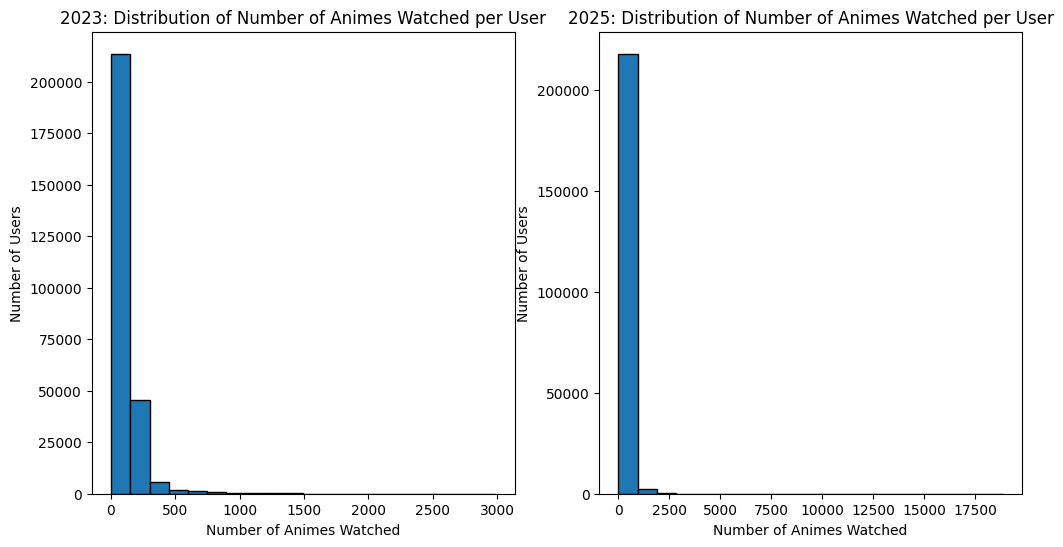

In [57]:
# Create two sub figures for 2023 and 2025 histograms
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(watch_count_23, bins=20, edgecolor='black')
plt.title("2023: Distribution of Number of Animes Watched per User")
plt.xlabel("Number of Animes Watched")
plt.ylabel("Number of Users")
plt.subplot(1, 2, 2)
plt.hist(watch_count_25, bins=20, edgecolor='black')
plt.title("2025: Distribution of Number of Animes Watched per User")
plt.xlabel("Number of Animes Watched")
plt.ylabel("Number of Users")
plt.show()

Distributions of the watch data

In [58]:
print(f"2023 Watchlist - Min: {watch_count_23.min()}, Max: {watch_count_23.max()}, Avg: {watch_count_23.mean():.2f}")
print(f"2025 Watchlist - Min: {watch_count_25.min()}, Max: {watch_count_25.max()}, Avg: {watch_count_25.mean():.2f}")

2023 Watchlist - Min: 1, Max: 2986, Avg: 90.08
2025 Watchlist - Min: 1, Max: 18857, Avg: 112.89


In [59]:
lower_23 = watch_count_23.quantile(0.1)
upper_23 = watch_count_23.quantile(0.9)
lower_25 = watch_count_25.quantile(0.1)
upper_25 = watch_count_25.quantile(0.9)

print(f"2023 Watchlist - Lower 10% threshold: {lower_23}, Upper 10% threshold: {upper_23}")
print(f"2025 Watchlist - Lower 10% threshold: {lower_25}, Upper 10% threshold: {upper_25}")

2023 Watchlist - Lower 10% threshold: 2.0, Upper 10% threshold: 264.0
2025 Watchlist - Lower 10% threshold: 2.0, Upper 10% threshold: 297.0


Calculate dataset boundaries

In [60]:
lower_threshold, upper_threshold = 10, 200
print(f"Lower threshold: {lower_threshold}", f"Upper threshold: {upper_threshold}")

Lower threshold: 10 Upper threshold: 200


Clean the 2023 datasets using lower and upper boundary

In [61]:
watch_cleaned_23 = watch_filtered_23[watch_filtered_23['user_id'].isin(
    watch_count_23[(watch_count_23 >= lower_threshold) & (watch_count_23 <= upper_threshold)].index
)]

Make the 2025 watch list only contain users that are also appear in 2023

In [62]:
common_users = set(watch_cleaned_23['user_id']).intersection(set(watch_filtered_25['user_id']))
watch_shrunk_23 = watch_filtered_25[watch_filtered_25['user_id'].isin(common_users)]

In [63]:
print (f"Number of common users in 2023 and 2025 watchlists: {len(common_users)}")

Number of common users in 2023 and 2025 watchlists: 71854


Save as processed

In [ ]:
def save_preprocessed_data(df: pd.DataFrame, file_path: str) -> None:
    """Save preprocessed data to a CSV file."""

    df.to_csv(file_path, index=False)

In [ ]:
save_preprocessed_data(anime_filtered, '../data/clean/anime-dataset-2023.csv')

save_preprocessed_data(watch_shrunk_23, '../data/clean/users-score-2023.csv')
save_preprocessed_data(watch_filtered_25, '../data/clean/users-score-2025.csv')